In [21]:
import gym
import random
import numpy as np
from statistics import median, mean
from collections import Counter
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque

In [22]:
LR = 1e-3
env = gym.make("CartPole-v1")
goal_steps = 500
TRAIN_EPISODES = 1500

CartPoleEnv - Version 0.2.0, Noise case: 1


In [23]:
#Plot score over episodes
def plot_res(values, title=''):   
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(100, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(500, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [24]:
def neural_network_model(input_size, output_size):

    model = Sequential()
    
    model.add(Dense(32, input_dim=input_size,activation='relu'))
    #model.add(LSTM(32, input_shape=(input_size,1), activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_size,activation='linear'))
    
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    
    return model

In [25]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print(input_size)
print(output_size)

model = neural_network_model(input_size, output_size)
target_model = neural_network_model(input_size, output_size)

4
2


In [26]:
epsilon = 1.0 #Used to define the exploration range
epsilon_min = 0.01
epsilon_decay = 0.995

def next_action(state, output_size):
    if(np.random.rand() <= epsilon): #Explore: Random action
        return random.randrange(output_size)
    return np.argmax(model.predict(state)) #Exploitation: Action with best possible reward

In [27]:
gamma = 0.9


def replay(model, training_data, train_size):
    global epsilon, epsilon_min, epsilon_decay
    
    batch_data = random.sample(training_data, train_size)
    for t in batch_data:
        state, reward, done, new_state, action = t
        
        yi = model.predict(state)
        
        if(done):
            yi[0][action] = reward
        else:
            a = model.predict(new_state)[0]
            t = target_model.predict(new_state)[0]
            yi[0][action] = reward + gamma * t[np.argmax(a)]
        model.fit(state, yi, epochs=1, verbose=0)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    return model

In [28]:
scores = []
game_memory = deque(maxlen=100000)

train_size = 32
update_every = 1

for game in range(TRAIN_EPISODES):
    state = env.reset()
    
    if game % update_every == 0:
        target_model.set_weights(model.get_weights())
    
    #env.render()
    score = 0
    for _ in range(goal_steps):
        state = state.reshape(-1, len(state))
        
        action = next_action(state, output_size)
                
        new_state, reward, done, info = env.step(action)
        
        score += reward
        if done:
            reward = -reward
        else:
            reward = reward
        
        game_memory.append((state, reward, done, new_state.reshape(-1, len(new_state)), action))
        
        state = new_state
        if done: 
            #print("episode: {}/{}, score: {}, e: {:.2}".format(game, EPISODES, _, epsilon))
            break
            
    if(len(game_memory) > train_size):
        replay(model, game_memory, train_size)
    
    if(game % 100 == 0):
        print('Game {} score : {}'.format(game, score))
        
    scores.append(score)
    
print('Average Score:',sum(scores)/len(scores))

Game 0 score : 17.0
Game 100 score : 21.0
Game 200 score : 33.0
Game 300 score : 107.0
Game 400 score : 122.0
Game 500 score : 94.0
Game 600 score : 111.0
Game 700 score : 108.0
Game 800 score : 120.0
Game 900 score : 224.0
Average Score: 104.73


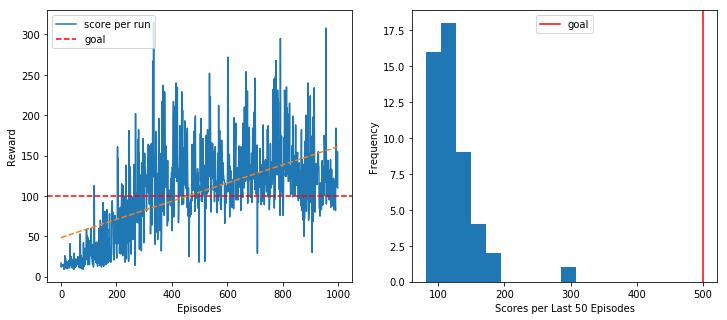

In [29]:
plot_res(scores)

In [30]:
model.save('model.h5')

In [31]:
model = load_model('model.h5')

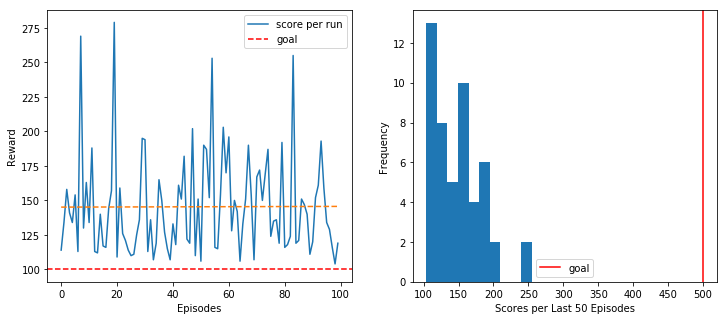

Average score over 100 episodes: 145.41


In [35]:
TEST_EPISODES = 100
goal_steps = 500
epsilon = 0.01
output_size = 2

scores = []
for episode in range(TEST_EPISODES):
    state = env.reset()
    
    score = 0
    for _ in range(goal_steps):
        env.render()
        
        state = state.reshape(-1, len(state))
        action = next_action(state, output_size)
        
        new_state, reward, done, info = env.step(action)
        score += reward
        
        state = new_state
        if(done):
            break
            
    scores.append(score)
        
plot_res(scores)        
print("Average score over {} episodes: {}".format(TEST_EPISODES, sum(scores)/len(scores)))